![PPGI_UFRJ](https://github.com/zavaleta/Fundamentos_DS/blob/main/imagens/ppgi-ufrj.png?raw=1)
# **Fundamentos de Ciência de Dados**

> Trabalho Final - 2º Período de 2022

### **Disponibilizando Dados sobre Resultados Financeiros de Cias Abertas Enriquecidos com Proveniência para a [OBInvest](https://obinvest.org/)**

---

**Alunos:** Gilberto Gil | Saulo Andrade Almeida | Valquire Jesus



## **FAIRificação**

In [1]:
#checking version machine architecture, OS, python and all libs used in this notebook
import platform as platform
import numpy as np
import pandas as pd
import os
import conda
import pydot
import prov

def checkingEnvironmentVersions(details=False):

    #definnig version of python and all libs used
    HOST_MACHINE_ARCHTECTURE_EXPECTED = 'x86_64'
    HOST_MACHINE_OS_EXPECTED = 'Linux'
    CONDA_VERSION_EXPECTED = '4.14.0'
    CONDA_DEFAULT_ENV_EXPECTED = 'drecvmenv'
    PYTHON_VERSION_EXPECTED = '3.9.12'
    NUMPY_LIB_VERSION_EXPECTED = '1.21.5'
    PANDAS_LIB_VERSION_EXPECTED = '1.4.2'
    PYDOT_LIB_VERSION_EXPECTED = '1.4.2'
    PROV_LIB_VERSION_EXPECTED = '2.0.0'
    

    if details: 
        print('Host Machine Architecture:', platform.machine())
        print('Host Machine OS:', platform.system())
        print('Conda Version:', conda.__version__)
        print('Conda default env:', os.environ['CONDA_DEFAULT_ENV'])
        print('Python Version:', platform.python_version())
        print('NumPy Lib Version:', np.__version__)
        print('Pandas Lib Version:', pd.__version__)
        print('PyDot Lib Version:', pydot.__version__)
        print('Prov Lib Version:', prov.__version__)
        
    #checking versions
    try:
        #checking Machine Architecute expected
        assert platform.machine() == HOST_MACHINE_ARCHTECTURE_EXPECTED

        #checking OS expected
        assert platform.system() == HOST_MACHINE_OS_EXPECTED
        
        #checking conda version
        assert conda.__version__ == CONDA_VERSION_EXPECTED
        
        #checking conda default environment
        assert os.environ['CONDA_DEFAULT_ENV'] == CONDA_DEFAULT_ENV_EXPECTED    

        #checking python version
        assert platform.python_version() == PYTHON_VERSION_EXPECTED

        #checking numpy lib version
        assert np.__version__ == NUMPY_LIB_VERSION_EXPECTED  

        #checking Pandas lib version
        assert pd.__version__ == PANDAS_LIB_VERSION_EXPECTED
        
        #checking pydot version
        assert pydot.__version__ == PYDOT_LIB_VERSION_EXPECTED
        
        #checking prov version
        assert prov.__version__ == PROV_LIB_VERSION_EXPECTED
    except:
        #if any assert fail, or something else get wrong during verification
        if details: print('Something is wrong!')
        return False
    else:
        #if pass all asserts
        if details: print('All versions are correct!')
        return True

## **Pré-processamento de Dados**

In [2]:
#Utilizado ambiente python 3.9
import pandas as pd
import numpy as np

def loadCsv(path, file):
  if path == 'data/cad-emp/':  # condição para fazer leitura do csv cadastro de companias
    return pd.read_csv(path+file, sep=';', header=0, encoding="ISO-8859-1")
  return pd.read_csv(path+file, sep=';', header=0, encoding="ISO-8859-1", parse_dates=['DT_REFER', 'DT_INI_EXERC', 
                                                                                       'DT_FIM_EXERC'])

def loadCompanyInfo():
    return loadCsv("data/cad-emp/", "cad_cia_aberta.csv")

def allHistoricalYears():
    return [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

def loadDreItr(years):
    tempDF = pd.DataFrame() 
    for year in years:
        tempDF = pd.concat([tempDF, loadCsv("data/dre-itr/","itr_cia_aberta_DRE_con_{0}.csv".format(year))], 
                           ignore_index=True)
    return tempDF

def loadDreDfp(years):
    tempDF = pd.DataFrame() 
    for year in years:
        tempDF = pd.concat([tempDF, loadCsv("data/dre-dfp/",f'dfp_cia_aberta_DRE_con_{year}.csv')], 
                           ignore_index=True)
    return tempDF

def loadAllDreItr():
    return loadDreItr(allHistoricalYears())

def loadAllDreDfp():
    return loadDreDfp(allHistoricalYears())

def carregar_datasets():
    companyInfoDF = loadCompanyInfo()
    dreItrDF = loadAllDreItr()
    dreDfpDF = loadAllDreDfp()
    return companyInfoDF, dreItrDF, dreDfpDF

def trata_dados_companhias(dataframe_cia):
    # TRATAMENTO DO DF CAD_CIA
    # filtrar as empresas com cadastro ativo - df cad_cia
    dataframe_cia = dataframe_cia[dataframe_cia['SIT'] == 'ATIVO']
    # deletar colunas desnecessárias
    dataframe_cia = dataframe_cia.drop(['DENOM_SOCIAL', 'DENOM_COMERC', 'DT_REG', 'DT_CONST', 'DT_CANCEL', 'MOTIVO_CANCEL', 'SIT', 
                   'DT_INI_SIT', 'TP_MERC', 'CATEG_REG', 'DT_INI_CATEG', 'SIT_EMISSOR', 'DT_INI_SIT_EMISSOR', 
                   'CONTROLE_ACIONARIO', 'TP_ENDER', 'LOGRADOURO', 'COMPL', 'BAIRRO', 'MUN', 'UF', 'PAIS', 
                   'CEP', 'DDD_TEL', 'TEL', 'DDD_FAX', 'FAX', 'EMAIL', 'TP_RESP', 'RESP', 'DT_INI_RESP', 
                   'LOGRADOURO_RESP', 'COMPL_RESP', 'BAIRRO_RESP', 'MUN_RESP', 'UF_RESP', 'PAIS_RESP', 
                   'CEP_RESP', 'DDD_TEL_RESP', 'TEL_RESP', 'DDD_FAX_RESP', 'FAX_RESP', 'EMAIL_RESP', 
                   'CNPJ_AUDITOR', 'AUDITOR'], axis=1)
    
    # deletar os registros duplicados, que possuem mesmos cnpj e códigos cvm
    dataframe_cia = dataframe_cia.drop_duplicates(subset = ['CNPJ_CIA', 'CD_CVM'], keep = 'last')
    
    #TODO:Gerar proveniencia do tratamento de companhias
    return dataframe_cia

def adiciona_ano(dataframe_dre):
    ano = []
    
    #adicionando as informacoes da coluna de Ano
    for i in dataframe_dre.itertuples():
        ano.append(i.DT_REFER.year)
    
    dataframe_dre['ANO'] = ano
    
    return dataframe_dre

def adiciona_trimestre(dataframe_dre):
    trimestre =[]
    
    #adicionando as informacoes da coluna de trimestre
    for i in dataframe_dre.itertuples():
      if i.DT_REFER.month == 3:
        trimestre.append(1)
      elif i.DT_REFER.month == 6:
        trimestre.append(2)
      elif i.DT_REFER.month == 9:
        trimestre.append(3)
      else:
        trimestre.append(4)
    
    dataframe_dre['TRIMESTRE'] = trimestre
    
    return dataframe_dre

def merge_dre_setor(dataframe_dre, dataframe_cia):
    return pd.merge(dataframe_dre, dataframe_cia, how = 'inner', on = ['CNPJ_CIA', 'CD_CVM']).reset_index(drop=True)
    
def filtrarUltimoExerc(dre):
    # Descartando resultados do ano anterior e mantendo apenas o último valor 
    return dre[dre['ORDEM_EXERC'] == 'ÚLTIMO']
    
def obter_trimestres_123(dataframe_itr):
    # FATIAMENTO DO DF ITR
    dataframe_itr = filtrarUltimoExerc(dataframe_itr)
    # OBTENÇÃO DO DF TRIMESTRES 1, 2 E 3
    # criar o df com informações dos trimestres 1 (1 a 3 mês), 2 (4 a 6 mês) e 3 (6 a 9 mês) - df trim123
    return dataframe_itr.loc[lambda dataframe_itr: (dataframe_itr.DT_REFER.dt.month == 3) | 
                            ((dataframe_itr.DT_REFER.dt.month == 6) & (dataframe_itr.DT_INI_EXERC.dt.month > 3)) | 
                            ((dataframe_itr.DT_REFER.dt.month == 9) & (dataframe_itr.DT_INI_EXERC.dt.month > 6))]

def obter_acumulado_trim3(dataframe_itr):
    # criar o df com informações acumuladas até o trimestre 3, 01/07/ANO a 30/09/ANO - df_acm3
    return dataframe_itr.loc[lambda dataframe_itr: ((dataframe_itr.DT_REFER.dt.month == 9) & 
                                                   (dataframe_itr.DT_INI_EXERC.dt.month <= 6))]

def obter_trimestre_4(dataframe_dfp, dataframe_acm3):
    # filtrar os informes acumulados no trimestre 4, 01/10/ANO a 31/12/ANO - df acm4
    df_acm4 = dataframe_dfp.loc[lambda df_dfp_setor: (dataframe_dfp.DT_REFER.dt.month == 12)]
    # fazer o merge entre df acumulado 4 e df acumulado 3, mantendo o df acumulado 4 - df trim4
    df_trim4 = pd.merge(df_acm4, dataframe_acm3, how='left', on=['CD_CVM', 'CD_CONTA', 'ANO'], suffixes=['_acm4','_acm3'])
    # preencher valores VL_CONTA ausentes com 0, informes que não foram enviados por Cias até o trimestre 3
    df_trim4.VL_CONTA_acm3.fillna(value=0, inplace=True)
    # calcular o valor do trimestre 4, fazendo a subtração entre acumulado anual e o acumulado do trimestre 3
    df_trim4['RESULTADO'] = df_trim4['VL_CONTA_acm4'] - df_trim4['VL_CONTA_acm3']
    # deletar colunas desnecessárias
    df_trim4 = df_trim4.drop(['VL_CONTA_acm4','CNPJ_CIA_acm3', 'DT_REFER_acm3', 'VERSAO_acm3', 'DENOM_CIA_acm3', 'GRUPO_DFP_acm3', 
                 'MOEDA_acm3', 'ESCALA_MOEDA_acm3', 'ORDEM_EXERC_acm3', 'DT_INI_EXERC_acm3', 'DT_FIM_EXERC_acm3', 
                 'DS_CONTA_acm3', 'VL_CONTA_acm3', 'ST_CONTA_FIXA_acm3','SETOR_ATIV_acm3'], axis=1)
    # renomear as colunas para a concatenação com o df trim123
    return df_trim4.rename(columns = {'CNPJ_CIA_acm4':'CNPJ_CIA', 'DT_REFER_acm4':'DT_REFER', 'VERSAO_acm4':'VERSAO', 
                             'DENOM_CIA_acm4':'DENOM_CIA', 'GRUPO_DFP_acm4':'GRUPO_DFP', 'MOEDA_acm4':'MOEDA', 
                             'ESCALA_MOEDA_acm4':'ESCALA_MOEDA', 'ORDEM_EXERC_acm4':'ORDEM_EXERC', 
                             'DT_INI_EXERC_acm4':'DT_INI_EXERC', 'DT_FIM_EXERC_acm4':'DT_FIM_EXERC', 
                             'DS_CONTA_acm4':'DS_CONTA', 'ST_CONTA_FIXA_acm4':'ST_CONTA_FIXA', 
                             'SETOR_ATIV_acm4':'SETOR_ATIV', 'RESULTADO':'VL_CONTA'})

def padronizacao_valor_conta(dataframe_dre):
    # PADRONIZAÇÃO DA COLUNA VL_CONTA
    # dividir por 1000 os valores em que a escala moeda é unidade
    dataframe_dre['VL_CONTA'] = dataframe_dre.apply(lambda x: x.VL_CONTA/1000 if x.ESCALA_MOEDA == 'UNIDADE' 
                                         else x.VL_CONTA, axis = 1)
    
    # renomear os dados da coluna escala moeda para o valor mil
    dataframe_dre['ESCALA_MOEDA'] = dataframe_dre.ESCALA_MOEDA.replace('UNIDADE', 'MIL')
    return dataframe_dre


# faz a limpeza dos datasets cad_cia, dre_itr e dre_dfp e retorna o dataset obinvest
def criar_dataset_obinvest():
    # carrega os datasets 
    df_cia, df_itr, df_dfp = carregar_datasets()

    #adicionar dados de Ano e Trimestres
    df_itr = adiciona_ano(df_itr)
    df_dfp = adiciona_ano(df_dfp)
    
    #Tratando dados de companhia
    df_cia = trata_dados_companhias(df_cia)
    
    # fazer merge entre cadastro e informe itr, obtendo o df itr com setor - dfs cad_cia e itr
    df_itr_setor = merge_dre_setor(df_itr, df_cia)

    #Filtrando dados dos 3 primeiros trimestres e adicionando os campos de ano e 
    df_trim123 = obter_trimestres_123(df_itr_setor)

    # OBTENÇÃO DO DF ACUMULADO TRIMESTRE 3
    df_acm3 = obter_acumulado_trim3(df_itr_setor)
    
    #
    # FATIAMENTO DO DF DFP
    # filtrar últimos informes anuais - df dfp
    df_dfp = filtrarUltimoExerc(df_dfp)
    # fazer merge entre cadastro e informe itr, obtendo o df dfp com setor - dfs cad_cia e dfp
    df_dfp_setor = merge_dre_setor(df_dfp, df_cia)
    
    # OBTENÇÃO DO DF ACUMULADO TRIMESTRE 4
    df_trim4 = obter_trimestre_4(df_dfp_setor, df_acm3)
    
    # CRIAÇÃO DO DF OBINVEST
    # criar o df obinvest, concatenando os informes referentes aos 4 trimestres
    df_obinvest = pd.concat([df_trim123, df_trim4])
    
    # comparar registros antes e depois
    print('Antes: Linhas = {0} | Colunas = {1}'.format(df_obinvest.shape[0], df_obinvest.shape[1]))
    
    # deletar os registros duplicados
    df_obinvest.drop_duplicates(subset = ['CNPJ_CIA', 'CD_CVM', 'CD_CONTA', 'DT_INI_EXERC', 'DT_FIM_EXERC', 'ANO'], 
                              keep = 'last', inplace=True)
    
    print('Depois: Linhas = {0} | Colunas = {1}'.format(df_obinvest.shape[0], df_obinvest.shape[1]))
    
    #Adicionar dado de trimestre
    df_obinvest = adiciona_trimestre(df_obinvest)
    
    #padronizacao valores contas
    return padronizacao_valor_conta(df_obinvest)
    #return df_obinvest

## **Proveniência de Dados**

In [3]:
import sys, subprocess, datetime
from prov.model import ProvDocument, Namespace
from prov.dot import prov_to_dot
from IPython.display import Image

def inicializaProveniencia():
    # Creating an empty provenance document
    docProv = ProvDocument()

    # Declaring namespaces for various prefixes used in the excution of Randon Walk Experiment
    docProv.add_namespace('foaf', 'http://xmlns.com/foaf/0.1/')
    docProv.add_namespace('prov', 'http://www.w3.org/ns/prov#')
    docProv.add_namespace('void', 'http://vocab.deri.ie/void#')
    docProv.add_namespace('cvm', 'https://www.gov.br/cvm/pt-br')
    docProv.add_namespace('cvm-cademp', 'https://dados.cvm.gov.br/dados/CIA_ABERTA/CAD/DADOS/')
    docProv.add_namespace('cvm-dre-itr-2011', 'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/')
    docProv.add_namespace('cvm-dre-itr-2012', 'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/')
    docProv.add_namespace('cvm-dre-itr-2013', 'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/')
    docProv.add_namespace('cvm-dre-itr-2014', 'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/')
    docProv.add_namespace('cvm-dre-itr-2015', 'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/')
    docProv.add_namespace('cvm-dre-itr-2016', 'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/')
    docProv.add_namespace('cvm-dre-itr-2017', 'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/')
    docProv.add_namespace('cvm-dre-itr-2018', 'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/')
    docProv.add_namespace('cvm-dre-itr-2019', 'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/')
    docProv.add_namespace('cvm-dre-itr-2020', 'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/')
    docProv.add_namespace('cvm-dre-itr-2021', 'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/')
    docProv.add_namespace('cvm-dre-dfp-2010', 'https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/DFP/DADOS/')

    
    
    # Creating all entity
    entDsCadEmp = docProv.entity('cvm-cademp:cad_cia_aberta.csv', {'prov:label': 'Dataset com dados da empresas listadas na CVM', 'prov:type': 'void:Dataset'})
    
    entDreItr = docProv.entity('cvm:dre-trimestral', {'prov:label': 'Documrnto que representa o conceito de DREs do tipo Trimestral', 'prov:type': 'foaf:Document'})
    entDsDreItr2011 = docProv.entity("cvm-dre-itr-2011:itr_cia_aberta_2011.zip", {'prov:label': 'Dataset com DRE trimestrais, do ano de 2011', 'prov:type': 'void:Dataset'})
    docProv.wasDerivedFrom('cvm-dre-itr-2011:itr_cia_aberta_2011.zip', 'cvm:dre-trimestral')
    docProv.wasDerivedFrom('cvm-dre-itr-2011:itr_cia_aberta_DRE_con_2011.csv', 'cvm-dre-itr-2011:itr_cia_aberta_2011.zip')
    entDsDreItr2012 = docProv.entity("cvm-dre-itr-2012:itr_cia_aberta_2012.zip", {'prov:label': 'Dataset com DRE trimestrais, do ano de 2012', 'prov:type': 'void:Dataset'})
    docProv.wasDerivedFrom('cvm-dre-itr-2012:itr_cia_aberta_2012.zip', 'cvm:dre-trimestral')
    docProv.wasDerivedFrom('cvm-dre-itr-2012:itr_cia_aberta_DRE_con_2012.csv', 'cvm-dre-itr-2012:itr_cia_aberta_2012.zip')
    entDsDreItr2013 = docProv.entity("cvm-dre-itr-2013:itr_cia_aberta_2013.zip", {'prov:label': 'Dataset com DRE trimestrais, do ano de 2013', 'prov:type': 'void:Dataset'})
    docProv.wasDerivedFrom('cvm-dre-itr-2013:itr_cia_aberta_2013.zip', 'cvm:dre-trimestral')
    docProv.wasDerivedFrom('cvm-dre-itr-2013:itr_cia_aberta_DRE_con_2013.csv', 'cvm-dre-itr-2013:itr_cia_aberta_2013.zip')

    
    
    entDreDfp = docProv.entity('cvm:dre-anual', {'prov:label': 'Documento que representa o conceito de DREs do tipo Anual', 'prov:type': 'foaf:Document'})
    entDsDreDfp2010 = docProv.entity("cvm-dre-dfp-2010:dfp_cia_aberta_2010.zip", {'prov:label': 'Dataset com DRE anual, do ano de 2010', 'prov:type': 'void:Dataset'})
    docProv.wasDerivedFrom('cvm-dre-dfp-2010:dfp_cia_aberta_2010.zip', 'cvm:dre-anual')
    docProv.wasDerivedFrom('cvm-dre-dfp-2010:dfp_cia_aberta_DRE_con_2010.csv', 'cvm-dre-dfp-2010:dfp_cia_aberta_2010.zip')
    
    

    # Creating all Agents  
    agntCvm = docProv.agent("cvm:CVM", 
                            {"prov:type":"prov:Organization", "foaf:name":"Comissão de Valores Mobiliários"})
    
    # create activity of dataset creations
    actvCreateDs = docProv.activity("cvm:create-dataset")    
    
    # Generation
    docProv.wasGeneratedBy(entDsCadEmp, actvCreateDs)
    docProv.wasGeneratedBy(entDreItr, actvCreateDs)
    docProv.wasGeneratedBy(entDreDfp, actvCreateDs)
    
    docProv.wasAssociatedWith(actvCreateDs, agntCvm)

    ### END - Registering Retrospective Provenance 

    ### Optional outputs ####
    
    entity = "DRE-CVM-PROV"
    #Generating the outup - a  Provenance Graph
    dot = prov_to_dot(docProv)
    graph = entity+".png"
    dot.write_png(graph)

    #Generating the Serialization - Output XML
    docProv.serialize(entity + ".xml", format='xml') 

    #Generating the Serialization - Output Turtle
    docProv.serialize(entity + ".ttl", format='rdf', rdf_format='ttl')

## **Análise de Dados**
### **Análise Inicial dos Dados**

In [4]:
def analiseInicialDataset(dataframe_obinvest):
    print(dataframe_obinvest.shape)
    print(dataframe_obinvest.isnull().sum())
    print(dataframe_obinvest.describe())
    print(dataframe_obinvest.columns)
    print(dataframe_obinvest.DT_REFER.value_counts())
    print(dataframe_obinvest.ESCALA_MOEDA.value_counts())

### **Análise Estatística dos Dados**

In [5]:
def analiseEstatisticaDataset(dataFrameObinvest):
    print('Rodando experimento de dataset estatisticos')

## **Execução Principal**

In [6]:
def executaExperimento():
    inicializaProveniencia()
    df_obinvest = criar_dataset_obinvest()
    analiseInicialDataset(df_obinvest)
    analiseEstatisticaDataset(df_obinvest)

Host Machine Architecture: x86_64
Host Machine OS: Linux
Conda Version: 4.14.0
Conda default env: drecvmenv
Python Version: 3.9.12
NumPy Lib Version: 1.21.5
Pandas Lib Version: 1.4.2
PyDot Lib Version: 1.4.2
Prov Lib Version: 2.0.0
All versions are correct!
Antes: Linhas = 554729 | Colunas = 17
Depois: Linhas = 449845 | Colunas = 17
(449845, 18)
CNPJ_CIA         0
DT_REFER         0
VERSAO           0
DENOM_CIA        0
CD_CVM           0
GRUPO_DFP        0
MOEDA            0
ESCALA_MOEDA     0
ORDEM_EXERC      0
DT_INI_EXERC     0
DT_FIM_EXERC     0
CD_CONTA         0
DS_CONTA         0
VL_CONTA         0
ST_CONTA_FIXA    0
ANO              0
SETOR_ATIV       0
TRIMESTRE        0
dtype: int64
              VERSAO         CD_CVM      VL_CONTA            ANO  \
count  449845.000000  449845.000000  4.498450e+05  449845.000000   
mean        1.242290   16229.804706 -6.099875e+10    2016.499434   
std         0.556448    7221.152127  4.091218e+13       3.216595   
min         1.000000     

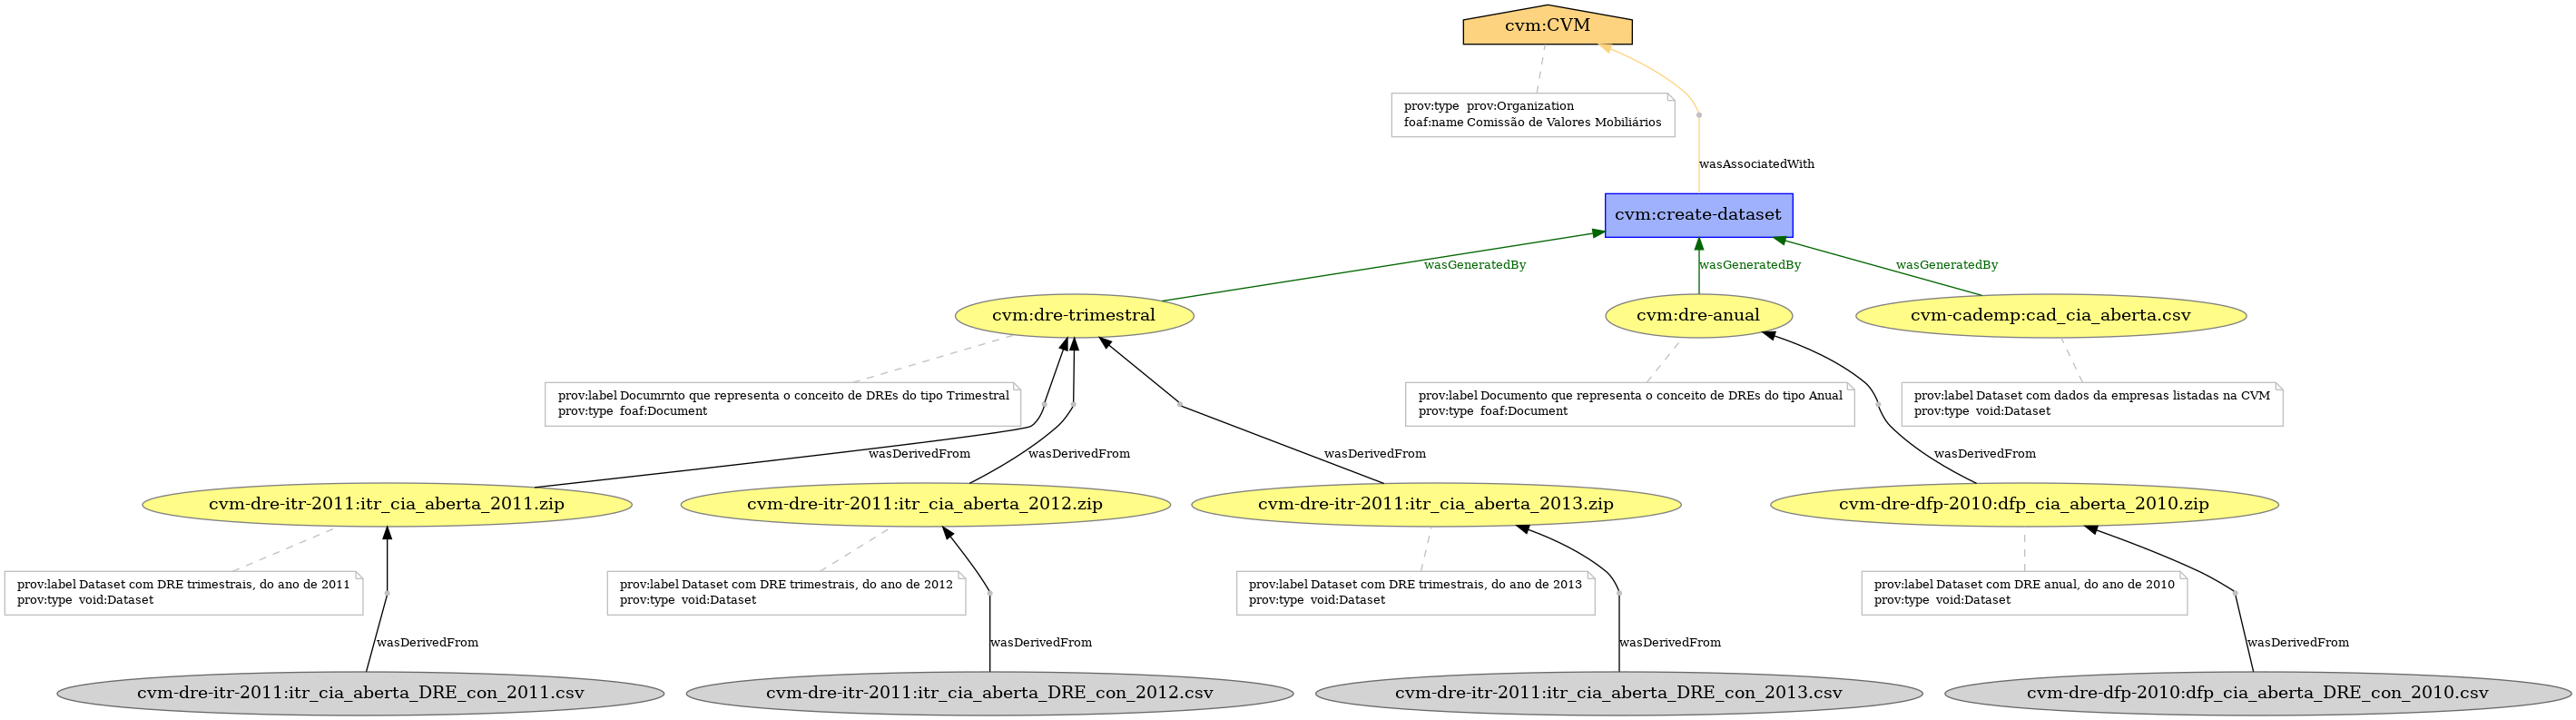

In [7]:
def main():
    if(checkingEnvironmentVersions(True)):
        executaExperimento()
        
main() # condição suspensa para poder rodar no notebook local

Image("DRE-CVM-PROV.png")